## 0. Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../utils')
from load_data import ames_housing
from preprocess_data import cat2int

import functools
import tensorflow as tf
#from tensorflow.python.feature_column.feature_column import _LazyBuilder
tf.__version__

'1.9.0'

## 1. Load data

In [3]:
dirfolder = '../data/Ames-Housing'
numvalid = 100
(traindf, trainy), (validdf, validy), testdf = ames_housing(dirfolder, numvalid)

../utils/load_data.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  testdf_new['Id'] = test_ID


## 2. Preprocess input data

In [4]:
traindata = traindf.values
validdata = validdf.values
testdata = testdf.values

# normalization
max_val = np.max(traindata, axis=0)
min_val = np.min(traindata, axis=0)
for i in range(traindata.shape[1]):
    if max_val[i] != 0:
        traindata[:, i] = (traindata[:, i]-min_val[i])/(max_val[i]-min_val[i])
        validdata[:, i] = (validdata[:, i]-min_val[i])/(max_val[i]-min_val[i])
        testdata[:, i] = (testdata[:, i]-min_val[i])/(max_val[i]-min_val[i])

## 3. Create dataflow graphs

In [12]:
# hyperparameters
lr_decay = 1.0
lr_0 = 0.1
batch_size = 32
iterations = 500000
monitor = 10000
perf_reduce = 0.5
keep_prob_input_0 = 0.8
keep_prob_a_0 = 0.5

# network size
num_train, num_in = traindata.shape
num_hidden_1 = 300
num_hidden_2 = 100
num_hidden_3 = 50
num_out = 1

# create network graph
## input and hidden layer 1
x = tf.placeholder(tf.float32, [None, num_in])
keep_prob_input = tf.placeholder(tf.float32)
keep_prob_a = tf.placeholder(tf.float32)
x_drop = tf.nn.dropout(x, keep_prob_input)
W_1 = tf.Variable(tf.random_normal([num_in, num_hidden_1], stddev=0.1))
b_1 = tf.Variable(tf.random_normal([num_hidden_1], stddev=0.1))
y_1 = tf.matmul(x_drop, W_1) + b_1
a_1 = tf.nn.selu(y_1)
bn_a_1 = tf.layers.batch_normalization(a_1)
a_1_drop = tf.nn.dropout(bn_a_1, keep_prob_a)

## hidden layer 1 and 2
W_2 = tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2], stddev=0.1))
b_2 = tf.Variable(tf.random_normal([num_hidden_2], stddev=0.1))
y_2 = tf.matmul(a_1_drop, W_2) + b_2
a_2 = tf.nn.selu(y_2)
bn_a_2 = tf.layers.batch_normalization(a_2)
a_2_drop = tf.nn.dropout(bn_a_2, keep_prob_a)

## hidden layer 2 and 3
W_3 = tf.Variable(tf.random_normal([num_hidden_2, num_hidden_3], stddev=0.1))
b_3 = tf.Variable(tf.random_normal([num_hidden_3], stddev=0.1))
y_3 = tf.matmul(a_2_drop, W_3) + b_3
a_3 = tf.nn.selu(y_3)
bn_a_3 = tf.layers.batch_normalization(a_3)
a_3_drop = tf.nn.dropout(bn_a_3, keep_prob_a)

## hidden layer 3 and output 
W_4 = tf.Variable(tf.random_normal([num_hidden_3, num_out], stddev=0.1))
b_4 = tf.Variable(tf.random_normal([num_out], stddev=0.1))
y_out = tf.matmul(a_3_drop, W_4) + b_4

# create training graph
learning_rate = tf.placeholder(tf.float32)
y_ = tf.placeholder(tf.float32, [None, num_out])
cost = tf.losses.mean_squared_error(y_, y_out)
train = tf.train.AdadeltaOptimizer(learning_rate).minimize(cost)

## 4. Training

In [13]:
# initialize
session = tf.Session()
session.run(tf.global_variables_initializer())

# train
start = 0
last_perf_train = np.inf
last_perf_valid = np.inf
best_perf_valid = np.inf
saver = tf.train.Saver()
for i in range(iterations):
    session.run(train, feed_dict={x: traindata[start:start+batch_size, :], 
                                  y_: trainy[start:start+batch_size],
                                  keep_prob_input: keep_prob_input_0,
                                  keep_prob_a: keep_prob_a_0, 
                                  learning_rate: lr_0})
    start += batch_size
    if start > num_train-batch_size: 
        start = 0
    if i % monitor == 0:
        perf_train = session.run(cost, feed_dict={x: traindata, 
                                                  y_: trainy,
                                                  keep_prob_input: 1.0,
                                                  keep_prob_a: 1.0})
        perf_valid = session.run(cost, feed_dict={x: validdata, 
                                                  y_: validy,
                                                  keep_prob_input: 1.0,
                                                  keep_prob_a: 1.0})
        if ((perf_valid-best_perf_valid)/best_perf_valid > perf_reduce):
            print("Performance degrades extremely. Training stops.")
            break
        last_perf_train = perf_train
        last_perf_valid = perf_valid
        if perf_valid < best_perf_valid:
            save_path = saver.save(session, "model/dnnreg_model.ckpt")
            print("Better model has been saved.")
            best_perf_valid = perf_valid
        lr_0 = lr_0*lr_decay
        print("{}: {}, {}".format(i, perf_train, perf_valid))
session.close()

Better model has been saved.
0: 145.66697692871094, 146.79518127441406
Better model has been saved.
10000: 0.061622463166713715, 0.0602789968252182
Better model has been saved.
20000: 0.05604904517531395, 0.052798427641391754
30000: 0.0588851273059845, 0.05478157103061676
40000: 0.08380597829818726, 0.07828108221292496
50000: 0.0590752437710762, 0.05397389084100723
Better model has been saved.
60000: 0.04192197695374489, 0.03834383562207222
Difference between two consercutive costs is too small.


## 5. Predict

In [14]:
session = tf.Session()
saver.restore(session, 'model/dnnreg_model.ckpt')
perf_train = session.run(cost, feed_dict={x: traindata, 
                                          y_: trainy,
                                          keep_prob_input: 1.0,
                                          keep_prob_a: 1.0})
perf_valid = session.run(cost, feed_dict={x: validdata, 
                                          y_: validy,
                                          keep_prob_input: 1.0,
                                          keep_prob_a: 1.0})
print(perf_train, perf_valid)
predtrainy = session.run(y_out, feed_dict={x: traindata, 
                                           keep_prob_input: 1.0,
                                           keep_prob_a: 1.0})
predvalidy = session.run(y_out, feed_dict={x: validdata, 
                                           keep_prob_input: 1.0,
                                           keep_prob_a: 1.0})
predtesty = session.run(y_out, feed_dict={x: testdata, 
                                           keep_prob_input: 1.0,
                                           keep_prob_a: 1.0})
session.close()

INFO:tensorflow:Restoring parameters from model/dnnreg_model.ckpt
0.041922 0.0383438


## 5. Plot results

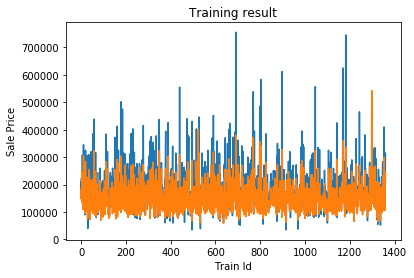

In [15]:
fig, ax = plt.subplots()
ax.plot(np.expm1(trainy), label='True')
ax.plot(np.expm1(predtrainy), label='Predict')
ax.set_xlabel('Train Id')
ax.set_ylabel('Sale Price')
ax.set_title('Training result');

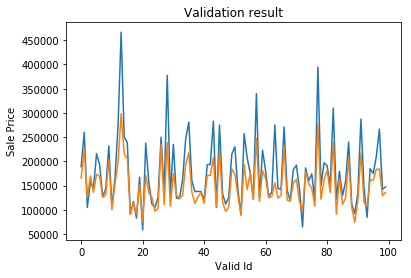

In [16]:
fig, ax = plt.subplots()
ax.plot(np.expm1(validy), label='True')
ax.plot(np.expm1(predvalidy), label='Predict')
ax.set_xlabel('Valid Id')
ax.set_ylabel('Sale Price')
ax.set_title('Validation result');

## 6. Save testing result for submission

In [72]:
sub_dict = {'Id': testdf.index.tolist(), 'SalePrice': np.expm1(predtesty).flatten()}
dnnreg_submission = pd.DataFrame(sub_dict)
dnnreg_submission.set_index('Id', inplace=True)
dnnreg_submission.to_csv('dnnreg_submission')